In [1]:
%matplotlib inline


In [2]:
# Imports (taken from salvus tutorials)
import os

SALVUS_FLOW_SITE_NAME = os.environ.get("macbook", "local") # Site name given in the installation of Salvus flow
PROJECT_DIR = "simulation_wavefield_output"  
import pathlib
import numpy as np
import salvus.namespace as sn
import xarray as xr
import salvus.namespace as sn
from salvus.project.tools.processing import block_processing
from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)
import matplotlib.pyplot as plt
from matplotlib import animation
import obspy

# For wavefield output code
from salvus.mesh.unstructured_mesh_utils import read_model_from_h5
from salvus.toolbox.helpers import wavefield_output




--> Server: 'https://l.mondaic.com/licensing_server', User: 'salome.bachmann', Group: 'ETHZ_ERDW_EEG'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.84 seconds]


In [3]:
# Setup of the model domain as a box 
domain_2d = sn.domain.dim2.BoxDomain(x0=0, x1=1, y0=0, y1=1)
p = sn.Project.from_domain(path=PROJECT_DIR, domain=domain_2d, load_if_exists=True)


# Layered model setup according to mondaic docs
# Minimal and maximal x extent: same as domain box
x_min = 0.0
x_max = 1.0

# Defining extent of löayers (layers_x) and thickness / topography of layers (layers_y)
layers_x = [
    np.array([0.0, 1.0]),  # top boundary
    np.array([0.0, 1.0]),  # snow-air interface
    np.array([0.0, 1.0]),  # earth-snow interface 
    np.array([0.0, 1.0]),  # bottom boundary
]

layers_y = [
    np.array([1.0, 1.0]),        
    np.array([2/3, 2/3]),        
    np.array([1/3, 1/3]),        
    np.array([0.0, 0.0]),        
]


# Defining model parameters (vp, vs and rho) for earth, snow and air, earth and air velocities taken from https://pburnley.faculty.unlv.edu/GEOL452_652/seismology/notes/SeismicNotes10RVel.html
vp = np.array([2200, 300, 332])
vs = np.array([880, 150,0])
rho = np.array([2000, 800, 1.2250])


interpolation_styles = ["linear"] * len(layers_x)


splines = sn.toolbox.get_interpolating_splines(
    layers_x, layers_y, kind=interpolation_styles
)

# # Plotting the layer boundaries to check if they are correct
# f = plt.figure(figsize=(10, 5))
# x_plot = np.linspace(x_min, x_max)
# for top, bot in splines:
#     plt.plot(x_plot, top(x_plot))
#     plt.plot(x_plot, bot(x_plot))

# plt.xlabel("x (m)")
# plt.ylabel("y (m)")
# plt.title("Interfaces")
# plt.ylim(0,1.5)

# Genetarte mesh
# Maximum frequency to resolve with elements_per_wavelength.
max_frequency = 20.0

# Print lenght of splines because of size mismatch between splines and vs
shp = len(splines)
print(shp)

slowest_velocities = np.array([
    880,   # earth
    150,   # snow
    150,   # air layer meshing controlled by snow below --> need this because else slowest_velocities gives an errror because it goes to infinity
])

# Generate the mesh
mesh, bnd = sn.toolbox.generate_mesh_from_splines_2d(
    x_min=0,
    x_max=x_max,
    splines=splines,
    elements_per_wavelength=2,
    maximum_frequency=max_frequency,
    use_refinements=True,
    slowest_velocities=slowest_velocities,
    absorbing_boundaries=(["x0", "x1", "y0"], 10.0), # Change this if different boundaries need to be absorbing 
)

mesh = np.sum(mesh)

# Add info about absorbing boundaries CHANGE DEPENDING ON WHICH BOUNDARIES NEED TO BE TRANSPARENT / ABSORBING
mesh.attach_global_variable("max_dist_ABC", bnd)
mesh.attach_global_variable("ABC_side_sets", ", ".join(["x0", "x1", "y0"]))
mesh.attach_global_variable("ABC_vel", float(min(vs)))
mesh.attach_global_variable("ABC_freq", max_frequency / 2.0)
mesh.attach_global_variable("ABC_nwave", 5.0)


# Attaching parameters (vp,vs,rho) to mesh 
nodes = mesh.get_element_nodes()[:, :, 0]
vp_a, vs_a, ro_a = np.ones((3, *nodes.shape))
for _i, (vp_val, vs_val, ro_val) in enumerate(zip(vp, vs, rho)):
    # Find which elements are in a given region.
    idx = np.where(mesh.elemental_fields["region"] == _i)

    # Set parameters in that region to a constant value.
    vp_a[idx] = vp_val
    vs_a[idx] = vs_val
    ro_a[idx] = ro_val

# Attach parameters.
for k, v in zip(["VP", "VS", "RHO"], [vp_a, vs_a, ro_a]):
    mesh.attach_field(k, v)

# Attach acoustic / elastic flag.
mesh_2d_layered = sn.toolbox.detect_fluid(mesh)

# # Checking which values are assigned to which layer: LAYER 0 IS THE BOTTOM LAYER
# np.unique(mesh.elemental_fields["region"])
# for i in range(3):
#     idx = mesh.elemental_fields["region"] == i
#     print(i,
#           np.unique(mesh.elemental_fields["VP"][idx]),
#           np.unique(mesh.elemental_fields["VS"][idx]),
#           np.unique(mesh.elemental_fields["RHO"][idx]))


# # Plot Mesh toc heck
# mesh_2d_layered



Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

[2026-01-13 17:16:52,573] INFO: Loading project from simulation_wavefield_output.
3


In [4]:
# Soure located at the top of the domain 
src = sn.simple_config.source.cartesian.VectorPoint2D(
    x=0.5,
    y=1.0,
    fx=0.0,
    fy=-1.0,
) # fx and fy values dependend on the type and force of source

p.add_to_project(sn.Event(event_name="event_wavefield_output", sources=[src]))

[2026-01-13 17:16:52,591] INFO: An event with name 'event_wavefield_output' and identical content already exists in the project. Nothing will be done.


In [5]:
# For layered model 
p.add_to_project(
    sn.UnstructuredMeshSimulationConfiguration(
        name="sim_2d_layered",
        unstructured_mesh=mesh_2d_layered,
        event_configuration=sn.EventConfiguration(
        wavelet=sn.simple_config.stf.Ricker(center_frequency=2.5),
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=2.0
            ),
        ),
    ),
)
# p.viz.nb.simulation_setup("sim_2d_layered", events=["event_wavefield_output"])

[2026-01-13 17:16:52,629] INFO: This exact entity is already part of the project. Nothing will be done. The comparison to the existing mesh was fairly expensive as it is (depending on the mesh size) a large amount of data that has to be compared. So best only add it once!


In [9]:
# Layered
p.simulations.launch(
    simulation_configuration="sim_2d_layered",
    events=p.events.list(),
    site_name="macbook", 
    ranks_per_job=1,
    extra_output_configuration={
        "volume_data": {
            "sampling_interval_in_time_steps": 10,
            "fields": ["velocity"],
        },
    },
)
p.simulations.query(block=True)


[2026-01-13 17:17:11,880] INFO: Data for 1 event(s) already exists. They will not be submitted again. The requested extra_output_configuration is fully contained in the existing results. If you really want to rerun the simulations, please delete the results first using p.simulations.delete_results().


VBox()

True

Finding enclosing elements (pass 1 of auto):   0%|          | 0/10201 [00:00<?, ?it/s]

Finding enclosing elements (pass 2 of auto):   0%|          | 0/3434 [00:00<?, ?it/s]

Finding enclosing elements (pass 3 of auto):   0%|          | 0/3434 [00:00<?, ?it/s]

Finding enclosing elements (pass 4 of auto):   0%|          | 0/3434 [00:00<?, ?it/s]

Finding enclosing elements (pass 5 of auto):   0%|          | 0/3434 [00:00<?, ?it/s]

Finding enclosing elements (pass 6 of auto):   0%|          | 0/3434 [00:00<?, ?it/s]

[2026-01-13 17:16:53,305] WARNING - salvus.mesh.algorithms.unstructured_mesh.utils: 3434 points were not claimed by enclosing elements. Depending on your use case, this may not be an issue.


Extracting wavefield to regular grid:   0%|          | 0/2 [00:00<?, ?it/s]

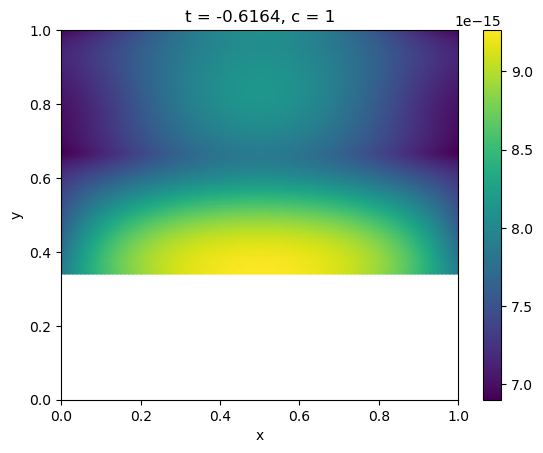

In [7]:
# Layered model 
out_2d_layered = p.simulations.get_simulation_output_directory("sim_2d_layered", "event_wavefield_output")

vel_wo_layered = wavefield_output.WavefieldOutput.from_file(
    pathlib.Path(
        out_2d_layered,
        "volume_data_output.h5",
    ),
    "velocity",
    "volume",
)

# Converting to an x array
vel_2d_layered = wavefield_output.wavefield_output_to_xarray(
    vel_wo_layered,
    points=[np.linspace(0, 1, 101), np.linspace(0, 1, 101)],
)

# Plotting wavefield output
# T is the timeslice (the t'th output image)
vel_2d_layered.isel(c=1, t=35).T.plot(shading="gouraud", infer_intervals=False)


In [ ]:
# layered model
# AN imation of wavefield output like in the code from stackeschange
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.dpi"] = 150
plt.ioff()

# getting wavefield output like above
out_2d_layered = p.simulations.get_simulation_output_directory(
    "sim_2d_layered", "event_wavefield_output"
)

vel_wo_layered = wavefield_output.WavefieldOutput.from_file(
    pathlib.Path(out_2d_layered, "volume_data_output.h5"),
    "velocity",
    "volume",
)

vel_2d_layered = wavefield_output.wavefield_output_to_xarray(
    vel_wo_layered,
    points=[np.linspace(0, 1, 101), np.linspace(0, 1, 101)],
)

# Setting up animation
fig, ax = plt.subplots()

# Initial frame at time t=0
quad_layered = vel_2d_layered.isel(c=1, t=0).T.plot(
    ax=ax,
    shading="gouraud",
    infer_intervals=False,
    add_colorbar=True
)

# Animation function: removes old mesh and adds new on e 
def animate(t):
    for coll in ax.collections:
        coll.remove()  
    vel_2d_layered.isel(c=1, t=t).T.plot(
        ax=ax,
        shading="gouraud",
        infer_intervals=False,
        add_colorbar=False,
    )
    ax.set_title(f"Velocity field (t = {t})")

# Creating animation
ani_layered = animation.FuncAnimation(
    fig,
    animate,
    frames=vel_2d_layered.sizes["t"],
    interval=100 # chnage interval to a higherr value for slower animation
)

ani_layered


Finding enclosing elements (pass 1 of auto):   0%|          | 0/10201 [00:00<?, ?it/s]

Finding enclosing elements (pass 2 of auto):   0%|          | 0/3434 [00:00<?, ?it/s]

Finding enclosing elements (pass 3 of auto):   0%|          | 0/3434 [00:00<?, ?it/s]

Finding enclosing elements (pass 4 of auto):   0%|          | 0/3434 [00:00<?, ?it/s]

Finding enclosing elements (pass 5 of auto):   0%|          | 0/3434 [00:00<?, ?it/s]

Finding enclosing elements (pass 6 of auto):   0%|          | 0/3434 [00:00<?, ?it/s]

[2026-01-13 17:18:03,759] WARNING - salvus.mesh.algorithms.unstructured_mesh.utils: 3434 points were not claimed by enclosing elements. Depending on your use case, this may not be an issue.


Extracting wavefield to regular grid:   0%|          | 0/2 [00:00<?, ?it/s]

Animation size has reached 20990068 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
